# RandomForestClassifier

This notebook presents **a customized implementation of the random forest** algorithm in **classification mode**, allowing users to:

1. Define **their own splitting metric** for node decisions.
2. Enable node splitting based on one or **multiple conditions simultaneously**.

> **Reminder of splitting optimization :**
> 
> Splitting in a decision tree is achieved by **optimizing a metric**. For example, Gini optimization consists in **maximizing** the $\Delta_{Gini}$ :
> 
> *   **The Gini Index** represents the impurity of a group of observations based on the observations of each class (0 and 1):
> 
> $$ I_{Gini} = 1 - p_0^2 - p_1^2 $$
> 
> *   The metric to be maximized is $\Delta_{Gini}$, the difference between **the Gini index on the parent node** and **the weighted average of the Gini index between the two child nodes** ($L$ and $R$).
> 
> $$ \Delta_{Gini} = I_{Gini} - \frac{N_L * I_{Gini_L}}{N} - \frac{N_R * I_{Gini_R}}{N} $$
>
> At each node, the tree algorithm finds the split that minimizes $\Delta$ over all possible splits and over all features. Once the optimal split is selected, the tree is grown by recursively applying this splitting process to the resulting child nodes.

In [ ]:
# !pip install pandas

import pandas as pd

from custom_decision_trees import RandomForestClassifier

To illustrate this example, we use data from `titanic.csv`. The goal is to predict the survival of an individual according to various characteristics such as age, sex, etc.

In [3]:
df = (
    pd
    .read_csv("data/titanic.csv")
    [["Survived", "Pclass", "Age", "Fare", "Sex", "Embarked", "SibSp", "Parch"]]
    .dropna()
)

df["Sex"] = df["Sex"].map({"female": 0, "male": 1})
df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

df.head()

,Survived,Pclass,Age,Fare,Sex,Embarked,SibSp,Parch
0,0,3,22.0,7.2500,1,2,1,0
1,1,1,38.0,71.2833,0,0,1,0
2,1,3,26.0,7.9250,0,2,0,0
3,1,1,35.0,53.1000,0,2,1,0
4,0,3,35.0,8.0500,1,2,0,0


**To define your own splitting metric**, you need to create a class derived from the `custom_tree.metrics.MetricBase` model. This class must contain the same methods and object types as inputs and outputs. 

The `metric_data` parameter refers to the portion of the dataset required to compute the splitting metric. It should be provided as an argument to the `.fit` method when training the model.

> **Note**: the algorithm will always maximize the metric. So if you need minimization, the `.compute_metric` method must return the opposite of the metric.

Here is an example of class for the Gini index :

In [4]:
import numpy as np

from custom_decision_trees.metrics import MetricBase


class Gini(MetricBase):

    def __init__(
            self,
            n_classes: int = 2,
        ) -> None:
        
        self.n_classes = n_classes
        self.max_impurity = 1 - 1 / n_classes

    def compute_gini(
            self,
            metric_data: np.ndarray,
        ) -> float:

        y = metric_data[:, 0]
        
        nb_obs = len(y)

        if nb_obs == 0:
            return self.max_impurity

        props = [(np.sum(y == i) / nb_obs) for i in range(self.n_classes)]

        metric = 1 - np.sum([prop**2 for prop in props])

        return float(metric)

    def compute_metric(
            self,
            metric_data: np.ndarray,
            mask: np.ndarray,
        ):

        gini_parent = self.compute_gini(metric_data)
        gini_side1 = self.compute_gini(metric_data[mask])
        gini_side2 = self.compute_gini(metric_data[~mask])

        delta = (
            gini_parent -
            gini_side1 * np.mean(mask) -
            gini_side2 * (1 - np.mean(mask))
        )

        metadata = {"gini": round(gini_side1, 3)}

        return float(delta), metadata

Next, instantiate the `DecisionTree` by specifying the following parameters:

*   `metric`: an instance of your custom splitting metric class.
*   `nb_max_conditions_per_node`: the maximum number of simultaneous conditions allowed to split a node.
*   Additional standard random forest parameters (see documentation): `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, `n_jobs`.

In [6]:
gini = Gini()

random_forest_classifier = RandomForestClassifier(
    metric=gini,
    n_estimators=10,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    nb_max_conditions_per_node=2,
    nb_max_cut_options_per_var=10,
    bootstrap=True,
    max_samples=None,
    n_jobs=1,
)

Train the model using the `.fit` method.

Here, you must provide the `metric_data` portion of the dataset, which will be passed to the `compute_metric` method defined in your custom metric class.

In [7]:
features = ["Pclass", "Age", "Fare", "Sex", "Embarked", "SibSp", "Parch"]

X = np.array(df[features])
y = np.array(df["Survived"])
metric_data = np.array(df[["Survived"]])

random_forest_classifier.fit(
    X=X,
    y=y,
    metric_data=metric_data,
)

Print the tree using `.print_tree` to observe the **optimal metric values** at each node, as well as the metadata returned by your custom metric class.

As you can see, the algorithm has optimized the splits based on the custom metric (in this case, the Gini delta). Since `nb_max_conditions_per_node` was set to 2, the model chose to perform splits using up to two variables simultaneously.

In [8]:
random_forest_classifier.print_forest(
    n_estimators=3,
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

TREE 1:
[0] 712 obs -> delta gini = 0.0 | repartition = [430, 282] | {'gini': 0.478}
|   [1] (x["SibSp"] <= 2.0) AND (x["Fare"] > 15.81) | 333 obs -> delta gini = 0.06 | repartition = [140, 193] | {'gini': 0.487}
|   |   [3] (x["Fare"] <= 39.2) AND (x["Parch"] <= 0.0) | 104 obs -> delta gini = 0.02 | repartition = [59, 45] | {'gini': 0.491}
|   |   [4] (x["Fare"] > 39.2) OR (x["Parch"] > 0.0) | 229 obs -> delta gini = 0.02 | repartition = [81, 148] | {'gini': 0.457}
|   [2] (x["SibSp"] > 2.0) OR (x["Fare"] <= 15.81) | 379 obs -> delta gini = 0.06 | repartition = [290, 89] | {'gini': 0.359}
|   |   [5] (x["Sex"] <= 0.0) AND (x["Parch"] <= 0.0) | 79 obs -> delta gini = 0.07 | repartition = [31, 48] | {'gini': 0.477}
|   |   [6] (x["Sex"] > 0.0) OR (x["Parch"] > 0.0) | 300 obs -> delta gini = 0.07 | repartition = [259, 41] | {'gini': 0.236}

TREE 2:
[0] 712 obs -> delta gini = 0.0 | repartition = [426, 286] | {'gini': 0.481}
|   [1] (x["Parch"] <= 0.0) AND (x["Fare"] <= 24.15) | 364 obs -

For more visual interpretation, you can also obtain a graph with the `.plot_tree` method.

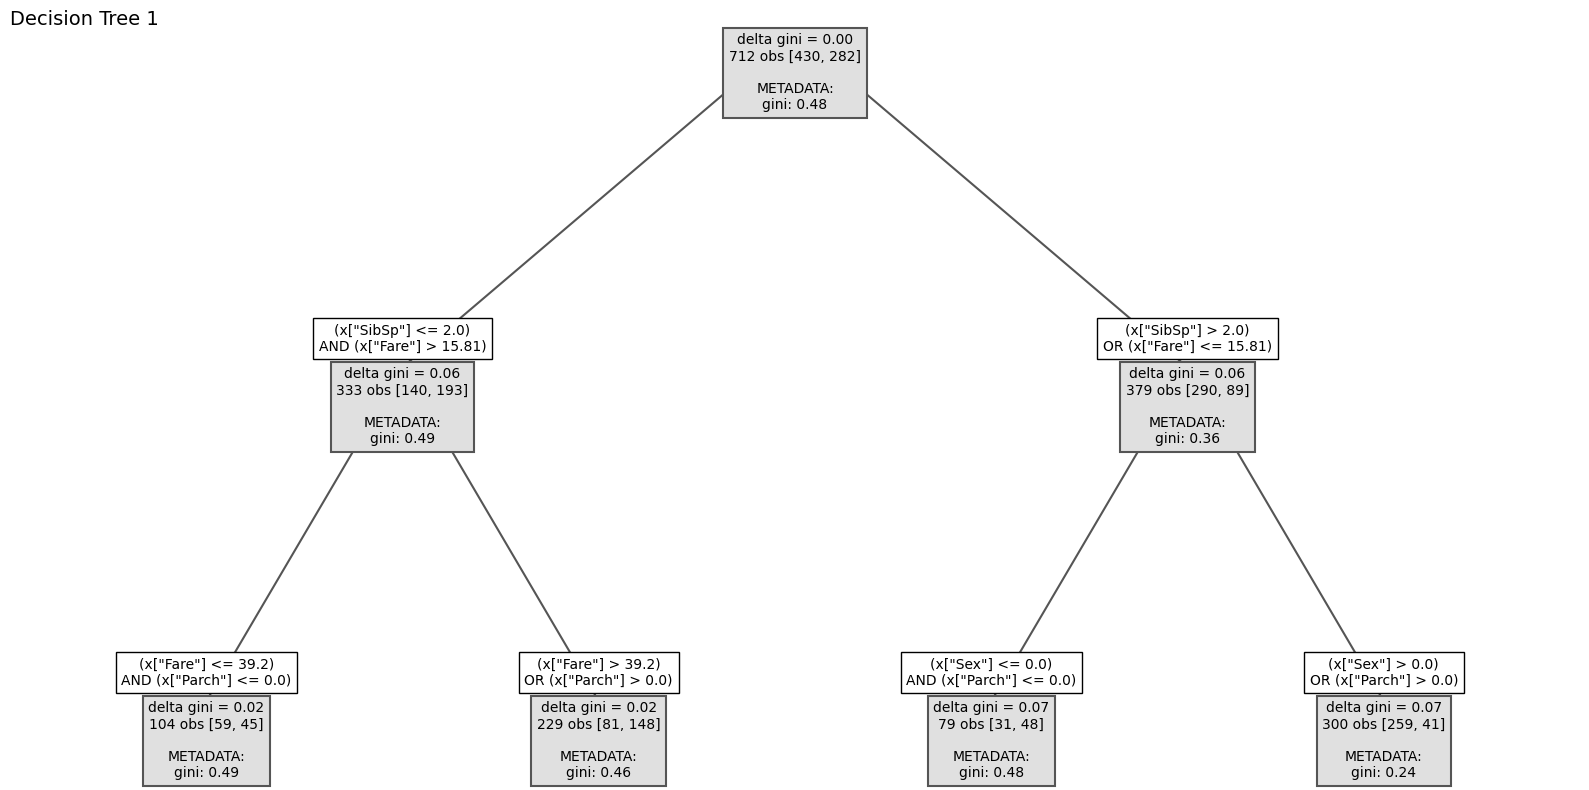

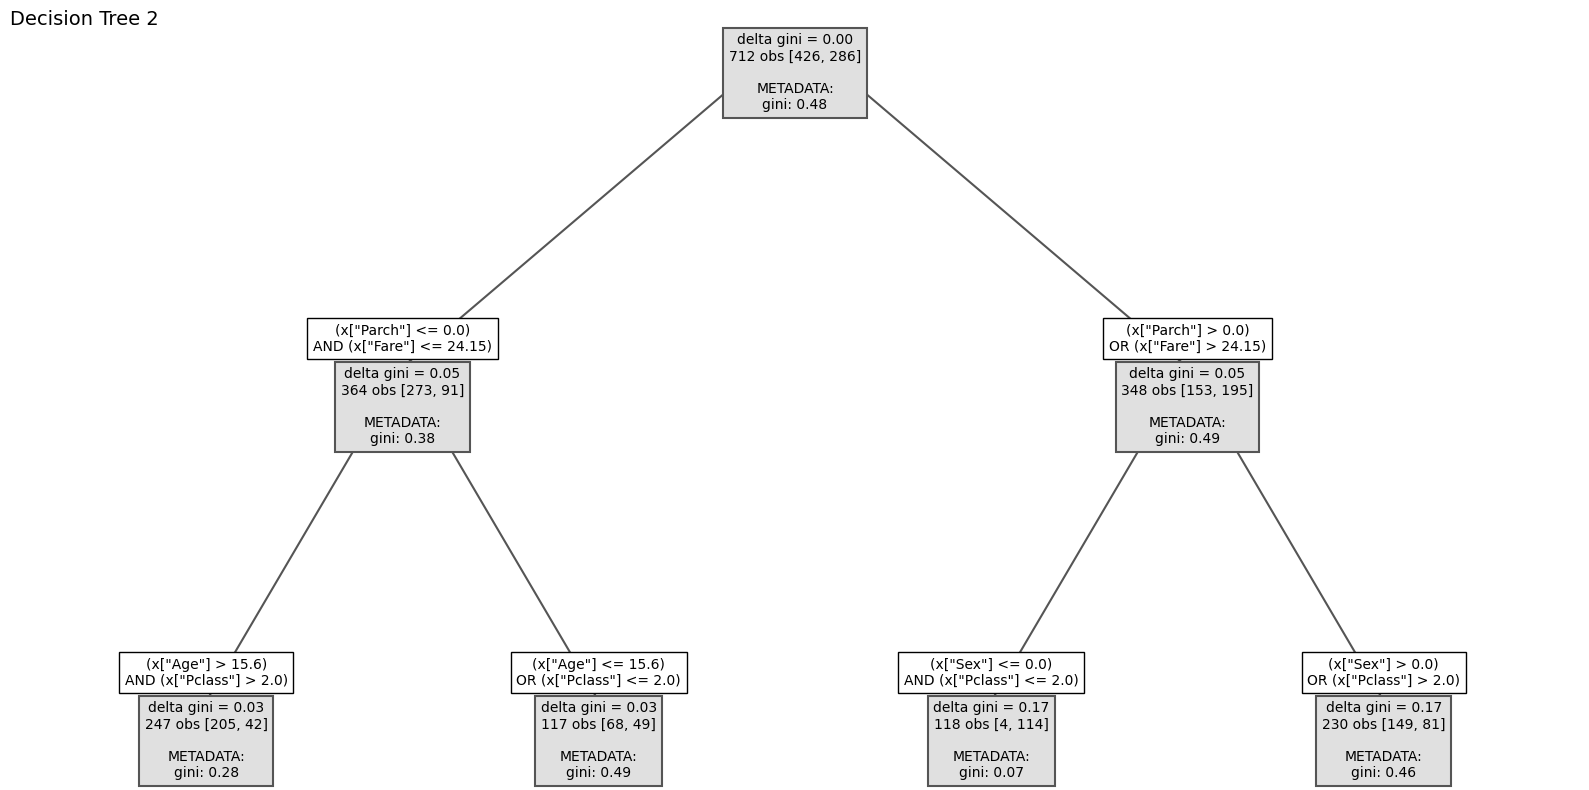

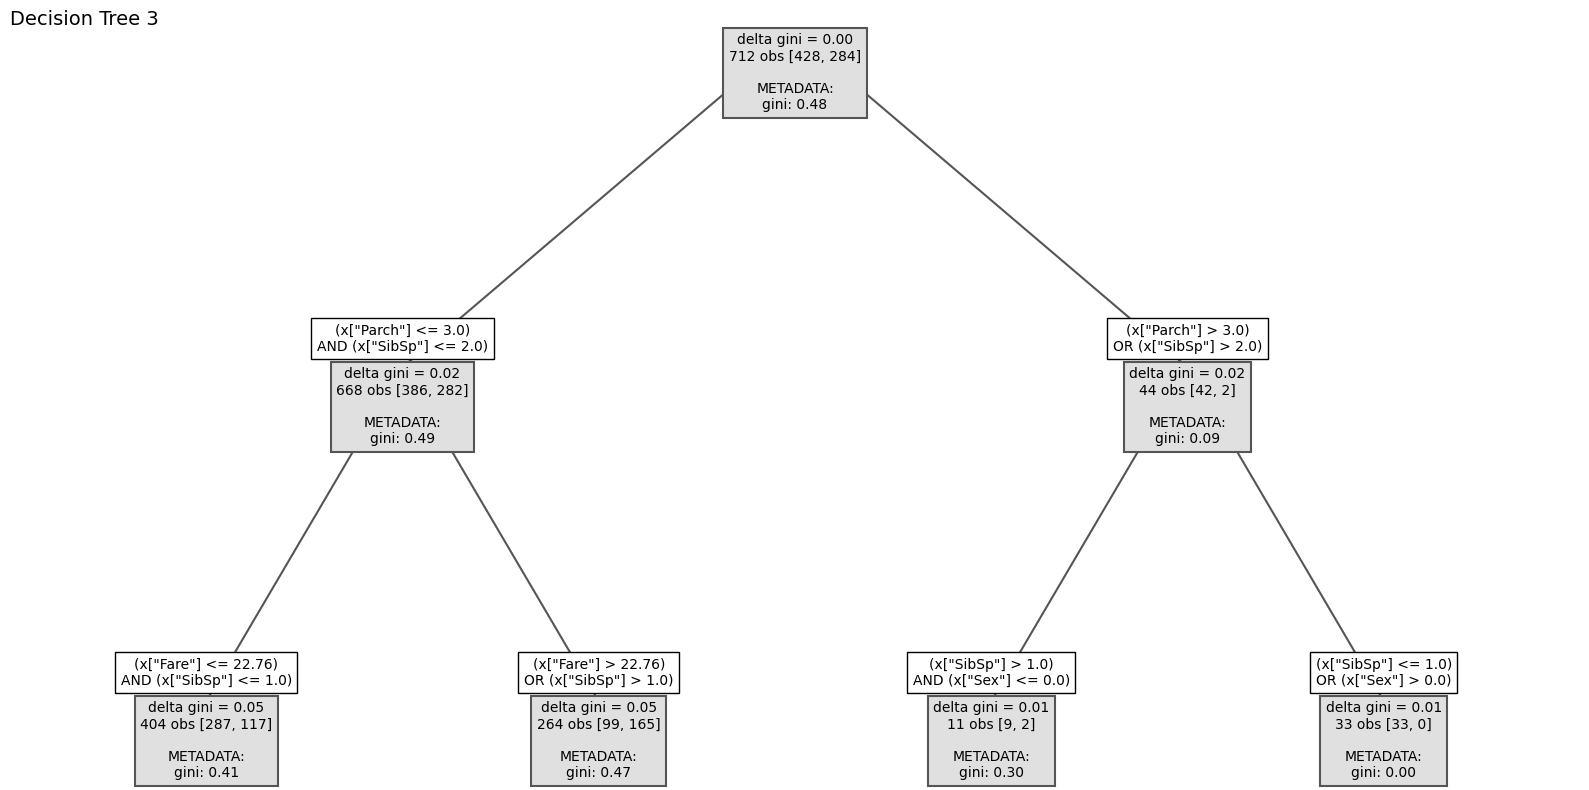

In [9]:
random_forest_classifier.plot_forest(
    n_estimators=3,
    max_depth=2,
    feature_names=features,
    show_repartition=True,
    show_metadata=True,
    digits=2,
    metric_name="delta gini",
    digits_metric=2,
    digits_filter=2,
)

Get the prediction with `.predict`

In [10]:
predictions = random_forest_classifier.predict(
    X=X
)

predictions[:5]

array([0, 1, 0, 1, 0])

Retrieve predicted probabilities with `predict_proba`

In [11]:
probas = random_forest_classifier.predict_proba(
    X=X
)

probas[:5]

array([[0.79204129, 0.20795871],
       [0.23570602, 0.76429398],
       [0.58736405, 0.41263595],
       [0.28380961, 0.71619039],
       [0.8084872 , 0.1915128 ]])

You can also obtain the complete predictions for each tree in the forest with `.predict_all`

In [12]:
predictions = random_forest_classifier.predict_all(
    X=X
)

predictions[:5]

[RandomForestPrediction(trees_predictions=[DecisionTreePrediction(value=[0.8633333333333333, 0.13666666666666666], metric=0.07318287149130016, metadata={'gini': 0.236}, path=[6, 2, 0]), DecisionTreePrediction(value=[0.8299595141700404, 0.1700404858299595], metric=0.026994878715526416, metadata={'gini': 0.282}, path=[3, 1, 0]), DecisionTreePrediction(value=[0.7103960396039604, 0.2896039603960396], metric=0.0537747280680235, metadata={'gini': 0.411}, path=[3, 1, 0]), DecisionTreePrediction(value=[0.9301310043668122, 0.06986899563318777], metric=0.08622682479105165, metadata={'gini': 0.13}, path=[6, 2, 0]), DecisionTreePrediction(value=[0.8081180811808119, 0.1918819188191882], metric=0.010818071178995387, metadata={'gini': 0.31}, path=[4, 1, 0]), DecisionTreePrediction(value=[0.8154362416107382, 0.18456375838926176], metric=0.025015284017724425, metadata={'gini': 0.301}, path=[3, 1, 0]), DecisionTreePrediction(value=[0.7201834862385321, 0.2798165137614679], metric=0.011447839436218687, me